## **Simulating Data for Python Didactics**
### VA Opioid and Benzodiazepene Dual-Prescription Among Veterans Dual-Enrolled in the VA Healthcare System and Medicare/Medicaid
#### **Author(s)**: Dominic DiSanto
#### **Written**: 6/29/2020
#### **Updated**: 09/09/2020
#### **Version**: 0.12

Inspiration from Dr. Paris's and Gellad's [publicily available cyberseminar](https://www.hsrd.research.va.gov/for_researchers/cyber_seminars/archives/video_archive.cfm?SessionID=3543) covering VA Pharmacy Data  
*(Most notably results contained in slides 34-42)*

#### **Introduction**  
The present notebook simulates a data set to be possibly used in a use case for the University of Pittsburgh's School of Pharmacy course *Python for Data Management and Analyatics* from Dr. Ravi Patel and Dr. Dmitriy Babichenko. This specific script was created under an internal open education resources grant at the University of Pittsburgh awarded to Dr. Patel, funding supplements to the course's current format with additional student resources, assessments, open resources, etc.  The notebook includes simulating two data sets including a subset of common patients with data available t be cleaned, merged, and visualized/analyzed. 
  
I should also explicitly acknowledge changes to the true/linked research that I've implemented to simplify some of the data simulation and the anticipated student work:
1. While the lecture and slides linked in the preamble identify patients based on a metric akin to "percentage of visits to VA hospitals vs using CMS benefits", I will simply dichotomize patients to "dual enrollment" (for those with a visit in both CMS and VA data sets) and "VA only". These groups can then be more simply identified, plotted, compared, etc.
3. Some overlapping patients (i.e. VA & CMS dual enrollment) will have overlapping prescriptions as well. The total dose will have to be summed between the two data sources to identify the true morphine mg equivalents taken by the patient (with all data assuming full medication adherence). 
4. I have reduced the number of medications dramatically and the required data cleaning to identify dose and length of use. This can always be upscaled to include more diverse/complicated medications, presentations, text, etc. 


> *I'll also acknowledge this code is likely far from best-practices for neat/concise Python programming; it includes redundant and unnecessarily long code. As a later goal, I would love to re-visit and improve this coding*

#### **General Goals/Uses of Generated Data**
The student assessment and the outlined walkthrough available in the GitHub repository will walk through the goals of this data in more depth. Below are brief bullet points used in my initial drafting and consideration of the data simulation for this use case. 

See `Student Assessment.MD` in GitHub repository for detailed student assessment and `ExampleSolution.ipynb` for a walkthrough/"solution" to the use case. Both of these documents will contain more detailed information and examples to capture the end-goal of this use case. 

1. Artificial data errors/cleaning tasks to demonstrate a Pharm/Meds related data set to work with character data, text matching/basic string data manipulation, and data merging (of "VA" and "CMS" data) 

2. Data management of identifying the outcome/risk factor of interest related to opioid administration, mg of morphone equivalents and related "over-prescription"
   
    
3. Data visualiation, trying to recreate a visualization similar to a provided plot in the student assessment (TBD tonight or tomorrow to create as of 9-9-2020). 

4. Lastly (and optionally, beyond the scope of Dr. Gellad's presentation) statistical inference/modelling related to predicting mortality to show that dual prescription and over-prescription are related to mortality, but that dual use of the two healthcare systems is protective when this does *not* occur.

### Notes for Data Simulation
I have currently not included the length of prescription, and was planning to simply let everyone assume all patients get a 30 day course. I'll then jitter the dates between VA and CMS dates (for dual enrolled patients) by some fairly normal distribution of say 14-42 days, average of 28. 

### Set Up 

In [1]:
import scipy as sci
import numpy as np
import pandas as pd
np.random.seed(1892)

#### General Process
***This notebook will:***
   1. Compile simulated VA patient visit data set  
   2. Sample some proportion of VA patients into CMS data set  
   3. Reconfigure sample data to meet CMS data formatting  
   4. Generate non-VA patients in CMS data set  
   5. Export data   
     
***Steps Outside of This Notebook***
   1. Upload relevant file to GitHub
   2. Develop prompt/problem
   3. Develop notebook that works through example "solution"

## **1) Simulate VA Patient Data Set**
### Generate Variables
#### **ID's (Fake, Scrambled SSN's)**

In [2]:
# Generate the VA data first, then sample and alter CMS data later
ids_num = np.random.randint(111111111, 999999999, 808)

display(ids_num[0:4]) # Just a quick test
display(len(ids_num))

array([609548877, 224736371, 601083249, 233862042])

808

#### **Age**

In [3]:
import matplotlib.pyplot as pyplot
age_va = [40 + np.random.beta(2.5, 0.8, size=505)*40]

for i in range(506, 809):
    age_va = np.append(age_va, 45 - np.random.beta(0.4, 0.37)*10)

age_va = np.round(age_va, 0)

display(len(age_va))
display(pyplot.hist(age_va))

808

(array([168.,  58.,  89.,  14.,  28.,  44.,  55.,  69., 107., 176.]),
 array([35. , 39.5, 44. , 48.5, 53. , 57.5, 62. , 66.5, 71. , 75.5, 80. ]),
 <a list of 10 Patch objects>)

#### **Height (cm)**
For simplicity, we will simply sample a normal distribution using my quick Google of an average male height of 175 cm and a roughly narrow distribution with sd +/- 9 cm.

147.58

207.17

(array([  7.,  30.,  81., 158., 197., 190., 105.,  32.,   5.,   3.]),
 array([147.58 , 153.539, 159.498, 165.457, 171.416, 177.375, 183.334,
        189.293, 195.252, 201.211, 207.17 ]),
 <a list of 10 Patch objects>)

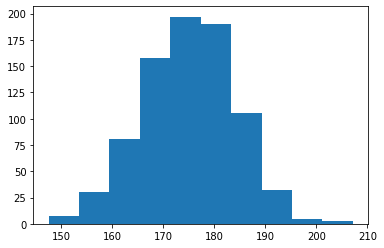

In [4]:
height_va = np.round(np.random.normal(loc=175, scale=9, size=808), 2)

display(height_va.min())
display(height_va.max())
display(pyplot.hist(height_va))

#### **Weight (kg)**
We will correlate weight to height with some small noise included. We will assume BMI should be roughly normally distributed of mean 31 and standard deviation of 2.8 [[loose reference for numbers I somewhat pulled from a hat]](https://dqydj.com/bmi-distribution-by-age-calculator-for-the-united-states/). As a result, we will randomly assign individuals a BMI, then back-calculate weight (and only keep the weight variable).

In [5]:
weight_va = np.round(np.random.normal(31, 2.8, 808) * np.square((height_va/100)), 2)
weight_va[1:100]

display(weight_va.min()*2.2046)
display(weight_va.max()*2.2046)

124.25125600000001

318.388332

#### **Medication**

In [6]:
medication_va = np.random.choice(['tramadol', 'tramadol HCL', 'buprenorphine', \
                                  'dihydrocodeine-acetaminophin-caff', 'dihydrocodeine', \
                                  'butorphanol', 'acetaminophen', 'ibuprofen', 'gabapentin'], \
                 size=808, replace=True, p = [0.1, 0.1, 0.15, 0.05, 0.05, 0.1, 0.1, 0.15, 0.2])

#### **Medication Dose Unit**

In [7]:
dose_unit_va = np.random.choice(['mg', 'mcg'], size=808, replace=True, p = [0.8, 0.2])

#### Med Dose 

In [8]:
dose_data_va = pd.DataFrame(data=medication_va, columns=['Medication'])
dose_data_va['Medication Dose Unit'] = dose_unit_va
dose_data_va['Medication Dose'] = np.nan

for i in range(0, dose_data_va.shape[0]):
    if dose_data_va.loc[i, 'Medication']=='acetaminophen':
        dose_data_va.loc[i, 'Medication Dose']= \
                np.random.choice([400, 750, 1000, 2500], p=[0.25, 0.45, 0.25, 0.05])
    if dose_data_va.loc[i, 'Medication']=='buprenorphine':
        dose_data_va.loc[i, 'Medication Dose']= \
                np.random.choice([0.15, 0.3, 0.6], p=[0.33, 0.34, 0.33])
    if dose_data_va.loc[i, 'Medication']=='butorphanol':
        dose_data_va.loc[i, 'Medication Dose']= \
                np.random.choice([2.5, 4, 6], p=[0.25, 0.4, 0.35])
    if dose_data_va.loc[i, 'Medication']=='dihydrocodeine-acetaminophin-caff'\
       or dose_data_va.loc[i, 'Medication']=='dihydrocodeine':
        dose_data_va.loc[i, 'Medication Dose']= \
                np.random.choice([16, 30, 60], p=[0.33, 0.34, 0.33])
    if dose_data_va.loc[i, 'Medication']=='gabapentin':
        dose_data_va.loc[i, 'Medication Dose']= \
                np.random.choice([300, 600], p=[0.75, 0.25])
    if dose_data_va.loc[i, 'Medication']=='ibuprofen':
        dose_data_va.loc[i, 'Medication Dose']= \
                np.random.choice([100, 200, 400], p=[0.33, 0.34, 0.33])
    if dose_data_va.loc[i, 'Medication']=='tramadol' or dose_data_va.loc[i, 'Medication']=='tramadol HCL':
        dose_data_va.loc[i, 'Medication Dose']= \
                np.random.choice([100, 200, 400], p=[0.35, 0.4, 0.25])
    if dose_data_va.loc[i, 'Medication Dose Unit']=='mcg':
        dose_data_va.loc[i, 'Medication Dose'] = dose_data_va.loc[i, 'Medication Dose']*1000

In [9]:
dose_data_va.sample(6)

,Medication,Medication Dose Unit,Medication Dose
352,gabapentin,mg,300.0
492,buprenorphine,mg,0.3
800,gabapentin,mg,300.0
705,gabapentin,mg,300.0
674,tramadol HCL,mg,200.0
520,ibuprofen,mg,200.0


#### **Visit Date**

In [10]:
# Shamelessly taken and only marginally adapted from the second answer at
# https://stackoverflow.com/questions/553303/generate-a-random-date-between-two-other-date

#from datetime import timedelta
from datetime import datetime
from datetime import timedelta
from random import randrange

start = datetime.strptime('1/1/2018', '%m/%d/%Y')
end = datetime.strptime('1/1/2020', '%m/%d/%Y')
visit_date_va=[]

for i in range(1,809):
    delta = end - start
    int_delta = (delta.days)
    rand_days = randrange(int_delta)
    x = start + timedelta(days=rand_days)
    visit_date_va.append(str(x)[0:10])

visit_date_va[0:10]

['2019-05-29',
 '2019-04-02',
 '2018-06-02',
 '2019-12-26',
 '2018-10-09',
 '2019-02-22',
 '2018-01-09',
 '2019-08-28',
 '2018-07-22',
 '2019-09-18']

#### Duration Value

In [11]:
# Will simply be a mix of days (14-35), months (1-2), and weeks (3-8) 
# I have no idea how long a typical script would be for these things so this could change
med_dur_va = np.random.choice( \
    np.concatenate([np.random.randint(1, 6, size=308), \
                    # randomly generating month, week values
                    np.random.randint(28, 60, size=500)]), \
                               # randomly generating day values
    size=808, replace=False) # np.choice resamples w/o replacement, effectively  rearranging the array


#### Duration Unit

In [12]:
# Duration unit will depend upon the value, not a lot of variability here
# values of 30+ will be days
# values of 1, 2 can be months or weeks 
# values of 4-8 will be weeks
#
med_data_va = pd.DataFrame(data=med_dur_va, columns=['Medication Duration'])
med_data_va['Duration Unit'] = ''

for i in range(0, med_data_va.shape[0]):
    med_data_va['Duration Unit'].iloc[i] = 'Day'
    if med_data_va['Medication Duration'].iloc[i]==1:
        med_data_va['Duration Unit'].iloc[i] = 'Month'# np.random.choice(['Month', 'Week'], p=[0.4, 0.6])
    if med_data_va['Medication Duration'].iloc[i]>1 and med_data_va['Medication Duration'].iloc[i]<10:
        med_data_va['Duration Unit'].iloc[i] = 'Week'# np.random.choice(['Month', 'Week'], p=[0.4, 0.6])
    
med_data_va.sample(10)

C:\Users\Dominic DiSanto\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,Medication Duration,Duration Unit
150,53,Day
110,5,Week
54,45,Day
175,1,Month
19,4,Week
264,46,Day
540,5,Week
748,44,Day
777,57,Day
87,2,Week


### Creating VA Data Frame

In [13]:
VA_data = pd.DataFrame({
    'Patient ID': ids_num, 
    'Visit Date': visit_date_va,
    'Age': age_va,
    'Height': height_va,
    'Weight': weight_va,
    'Medication': dose_data_va['Medication'],
    'Medication Dose': dose_data_va['Medication Dose'],
    'Medication Dose Unit': dose_data_va['Medication Dose Unit'],
    'Medication Duration Value': med_data_va['Medication Duration'],
    'Medication Duration Unit': med_data_va['Duration Unit']            
})

In [14]:
VA_data.sample(10)

,Patient ID,Visit Date,Age,Height,Weight,Medication,Medication Dose,Medication Dose Unit,Medication Duration Value,Medication Duration Unit
8,839072705,2018-07-22,75.0,176.01,94.06,gabapentin,300.0,mg,56,Day
6,594951177,2018-01-09,76.0,193.40,144.42,tramadol,400.0,mg,1,Month
344,618853094,2018-09-30,62.0,177.21,97.13,dihydrocodeine-acetaminophin-caff,60.0,mg,3,Week
102,680550980,2019-02-06,50.0,161.75,80.27,acetaminophen,750000.0,mcg,3,Week
618,499505840,2018-09-20,45.0,173.65,96.39,butorphanol,2.5,mg,3,Week
358,318968469,2018-08-17,63.0,191.77,109.38,gabapentin,300.0,mg,2,Week
399,551043414,2019-05-02,78.0,164.01,91.59,acetaminophen,1000.0,mg,44,Day
85,619950694,2018-06-26,53.0,178.29,93.76,acetaminophen,750.0,mg,41,Day
384,393662429,2019-01-08,44.0,157.40,78.25,butorphanol,4.0,mg,51,Day
538,877446334,2019-05-23,45.0,183.66,106.86,butorphanol,4.0,mg,58,Day


## **2. Sample some proportion of VA patients into CMS data set**
I will start by sampling a subset of rows from the VA data as our "dual-enrolled" patients (I chose 384 on a whim and as a roughly near-50/50 split, seems like a nice number idk). I'll then add new CMS style variables to this data frame, and finally retain only the CMS variables.

> Appending the new variables to the data frame will allow me to check-as-I-go to ensure I create the variables I'm intending to create. Then in a final step, I will simply keep only the CMS variables identified by a "*(CMS)*" suffix. 

In [15]:
CMS_VA_dual_pats = VA_data.sample(384).reset_index(drop=False) # keeping 
CMS_VA_dual_pats.head(4)

,index,Patient ID,Visit Date,Age,Height,Weight,Medication,Medication Dose,Medication Dose Unit,Medication Duration Value,Medication Duration Unit
0,591,646979801,2018-06-30,43.0,189.26,126.03,ibuprofen,400.0,mg,5,Week
1,105,553276047,2019-12-26,52.0,171.28,82.54,butorphanol,4.0,mg,34,Day
2,770,334303080,2019-05-23,44.0,164.78,78.44,butorphanol,2.5,mg,1,Month
3,361,949445667,2019-10-31,72.0,164.19,94.50,gabapentin,300.0,mg,3,Week


## **3. Reconfigure sample data to meet CMS data formatting**
Age will remain the same. Height and weight are dropped in the final steps from this data frame. Medication variables are randomly re-sampled (as if a new data set). As I work through creating the walkthrough document, I will think of how to re-adjust as necessary to have sufficient values of outcomes of interest. For now, I'll pray to the gods that randomization is on my side.

#### Patient ID 
Currently an integer, I will add in the hyphen's ("-") to represent the SSN structure of the ID variable, and to require students to work with substring or string replace and casting data types. 

In [16]:
CMS_VA_dual_pats['Patient ID (CMS)'] = ''
for i in range(0,CMS_VA_dual_pats.shape[0]):
    x = str(CMS_VA_dual_pats.loc[i, 'Patient ID'])
    ssn_r = x[0:3] + '-' + x[3:5] + "-" + x[5:10]
    CMS_VA_dual_pats.loc[i, 'Patient ID (CMS)'] = [ssn_r]
    
CMS_VA_dual_pats[['Patient ID', 'Patient ID (CMS)']].sample(6)

,Patient ID,Patient ID (CMS)
62,148722083,148-72-2083
12,485487112,485-48-7112
341,619680569,619-68-0569
60,624531141,624-53-1141
347,969703406,969-70-3406
40,441734513,441-73-4513


#### Medication 

In [17]:
CMS_VA_dual_pats['Medication (CMS)'] = ''

for i in range(0, CMS_VA_dual_pats.shape[0]):
    CMS_VA_dual_pats['Medication (CMS)'].loc[i] =  \
                                str(np.random.choice(['TRAMADOL', 'BUPRENORPHINE', 
                                    'BUPRENORPHINE TABLET', 'BUPERNORPHINE', \
                                    'DIHYDROCODEINE', 'BUTORPHANOL', 'IBUPROFEN', 'GABAPENTIN'], \
                                 p = [0.2, 0.1, 0.03, 0.02, 0.1, 0.1, 0.25, 0.2]))

#### Medication Dose Unit

In [18]:
CMS_VA_dual_pats['Medication Dose Unit (CMS)'] = ''

for i in range(0, CMS_VA_dual_pats.shape[0]):
    CMS_VA_dual_pats['Medication Dose Unit (CMS)'].loc[i] = \
    np.random.choice(['mg', 'mcg'], p = [0.8, 0.2])

#### Medication Dose (Dose) 

In [19]:
CMS_VA_dual_pats.loc[CMS_VA_dual_pats['Medication (CMS)']=='IBUPROFEN'].sample(5)

,index,Patient ID,Visit Date,Age,Height,Weight,Medication,Medication Dose,Medication Dose Unit,Medication Duration Value,Medication Duration Unit,Patient ID (CMS),Medication (CMS),Medication Dose Unit (CMS)
298,111,439213038,2018-08-26,69.0,186.69,109.98,buprenorphine,0.6,mg,3,Week,439-21-3038,IBUPROFEN,mg
205,232,695096607,2018-01-24,61.0,171.06,108.13,dihydrocodeine-acetaminophin-caff,30.0,mg,41,Day,695-09-6607,IBUPROFEN,mg
171,88,987018672,2018-01-13,80.0,176.07,90.99,gabapentin,300.0,mg,48,Day,987-01-8672,IBUPROFEN,mcg
256,235,937237305,2018-09-19,76.0,186.99,133.34,tramadol HCL,200.0,mg,31,Day,937-23-7305,IBUPROFEN,mg
18,362,945931854,2019-07-16,56.0,186.36,105.77,acetaminophen,400000.0,mcg,58,Day,945-93-1854,IBUPROFEN,mg


In [20]:
CMS_VA_dual_pats['Medication Dose (CMS)'] = np.nan

for i in range(0, CMS_VA_dual_pats.shape[0]):
    if CMS_VA_dual_pats.loc[i, 'Medication (CMS)']=='BURPRENORPHINE' \
       or CMS_VA_dual_pats.loc[i, 'Medication (CMS)']=='BUPERNORPHINE' or \
          CMS_VA_dual_pats.loc[i, 'Medication (CMS)']=='BURPRENORPHINE TABLET':
        CMS_VA_dual_pats.loc[i, 'Medication Dose (CMS)']= \
                np.random.choice([0.15, 0.3, 0.6], p=[0.33, 0.34, 0.33])
    if CMS_VA_dual_pats.loc[i, 'Medication (CMS)']=='BUTORPHANOL':
        CMS_VA_dual_pats.loc[i, 'Medication Dose (CMS)']= \
                np.random.choice([2.5, 4, 6], p=[0.25, 0.4, 0.35])
    if CMS_VA_dual_pats.loc[i, 'Medication (CMS)']=='DIHYDROCODEINE':
        CMS_VA_dual_pats.loc[i, 'Medication Dose (CMS)']= \
                np.random.choice([16, 30, 60], p=[0.33, 0.34, 0.33])
    if CMS_VA_dual_pats.loc[i, 'Medication (CMS)']=='GABAPENTIN':
        CMS_VA_dual_pats.loc[i, 'Medication Dose (CMS)']= \
                np.random.choice([300, 600], p=[0.75, 0.25])
    if CMS_VA_dual_pats.loc[i, 'Medication (CMS)']=='IBUPROFEN':
        CMS_VA_dual_pats.loc[i, 'Medication Dose (CMS)']= \
                np.random.choice([100, 200, 400], p=[0.33, 0.34, 0.33])
    if CMS_VA_dual_pats.loc[i, 'Medication (CMS)']=='TRAMADOL':
        CMS_VA_dual_pats.loc[i, 'Medication Dose (CMS)']= \
        np.random.choice([100, 200, 400], p=[0.35, 0.4, 0.25])
    if CMS_VA_dual_pats.loc[i, 'Medication Dose Unit (CMS)']=='mcg':
        CMS_VA_dual_pats.loc[i, 'Medication Dose (CMS)'] = \
        CMS_VA_dual_pats.loc[i, 'Medication Dose (CMS)']*1000

In [21]:
CMS_VA_dual_pats[['Medication (CMS)', 'Medication Dose (CMS)', 'Medication Dose Unit (CMS)']]

,Medication (CMS),Medication Dose (CMS),Medication Dose Unit (CMS)
0,DIHYDROCODEINE,16.00,mg
1,TRAMADOL,400000.00,mcg
2,TRAMADOL,400.00,mg
3,GABAPENTIN,300.00,mg
4,GABAPENTIN,300.00,mg
...,...,...,...
379,TRAMADOL,200.00,mg
380,IBUPROFEN,200.00,mg
381,BUTORPHANOL,4.00,mg
382,IBUPROFEN,400.00,mg


#### Duration Value

In [22]:
# Will simply be a mix of days (14-35), months (1-2), and weeks (3-8) 
# I have no idea how long a typical script would be for these things so this could change
cms_med_duration = np.random.choice( \
    np.concatenate([np.random.randint(1, 6, size=308), \
                    # randomly generating month, week values
                    np.random.randint(28, 60, size=500)]), \
                               # randomly generating day values
    size=CMS_VA_dual_pats.shape[0], replace=False) # np.choice resamples w/o replacement, effectively  rearranging the array

CMS_VA_dual_pats['Medication Duration (CMS)'] = cms_med_duration

#### Duration Unit

In [23]:
# Duration unit will depend upon the value, not a lot of variability here
# values of 30+ will be days
# values of 1, 2 can be months or weeks 
# values of 4-8 will be weeks
#
CMS_VA_dual_pats['Duration Unit (CMS)'] = ''

for i in range(0, CMS_VA_dual_pats.shape[0]):
    CMS_VA_dual_pats['Duration Unit (CMS)'].iloc[i] = 'Day'
    if CMS_VA_dual_pats['Medication Duration (CMS)'].iloc[i]==1:
        CMS_VA_dual_pats['Duration Unit (CMS)'].iloc[i] = 'Month'
    if CMS_VA_dual_pats['Medication Duration (CMS)'].iloc[i]>1\
    and CMS_VA_dual_pats['Medication Duration (CMS)'].iloc[i]<10:
        CMS_VA_dual_pats['Duration Unit (CMS)'].iloc[i] = 'Week'

#### Visit Date

In [24]:
rand_int = np.random.randint(-10, 10, size=CMS_VA_dual_pats.shape[0])

CMS_VA_dual_pats['Visit Date (CMS)'] = ''

for i in range(0, CMS_VA_dual_pats.shape[0]):
    CMS_VA_dual_pats['Visit Date (CMS)'].loc[i] = str( \
    datetime.strptime(CMS_VA_dual_pats['Visit Date'].loc[i], '%Y-%m-%d') \
    + timedelta(days=int(rand_int[i])))[0:10]
    
CMS_VA_dual_pats.sample(5)

,index,Patient ID,Visit Date,Age,Height,Weight,Medication,Medication Dose,Medication Dose Unit,Medication Duration Value,Medication Duration Unit,Patient ID (CMS),Medication (CMS),Medication Dose Unit (CMS),Medication Dose (CMS),Medication Duration (CMS),Duration Unit (CMS),Visit Date (CMS)
191,573,189472099,2018-02-02,36.0,167.56,86.25,tramadol HCL,100000.00,mcg,56,Day,189-47-2099,BUPRENORPHINE,mg,NaN,1,Month,2018-02-01
77,675,299076821,2019-10-11,43.0,172.42,86.28,gabapentin,600.00,mg,2,Week,299-07-6821,GABAPENTIN,mg,300.0,3,Week,2019-10-09
367,113,657735005,2019-07-03,64.0,179.23,101.78,dihydrocodeine,16.00,mg,28,Day,657-73-5005,IBUPROFEN,mg,400.0,49,Day,2019-07-02
133,96,421899900,2019-04-01,78.0,177.01,96.46,gabapentin,300.00,mg,3,Week,421-89-9900,DIHYDROCODEINE,mg,30.0,1,Month,2019-04-09
67,137,481615586,2019-12-23,77.0,167.84,90.83,buprenorphine,0.15,mg,49,Day,481-61-5586,BUPERNORPHINE,mcg,300.0,32,Day,2019-12-25


#### **Finalizing CMS Data Set**

In [25]:
CMS_vars = []
for i in CMS_VA_dual_pats.columns:
    if 'CMS' in i:
        CMS_vars.append(i) 
CMS_vars

['Patient ID (CMS)',
 'Medication (CMS)',
 'Medication Dose Unit (CMS)',
 'Medication Dose (CMS)',
 'Medication Duration (CMS)',
 'Duration Unit (CMS)',
 'Visit Date (CMS)']

In [26]:
CMS_data = CMS_VA_dual_pats[CMS_VA_dual_pats.columns.intersection(CMS_vars)]
CMS_data.columns = CMS_data.columns.str.rstrip(' (CMS)')
CMS_data.sample(10)

,Patient ID,Medication,Medication Dose Unit,Medication Dose,Medication Duration,Duration Unit,Visit Date
160,855-78-6519,IBUPROFEN,mg,200.0,4,Week,2019-08-01
94,356-45-5827,BUTORPHANOL,mg,2.5,46,Day,2019-01-30
381,868-81-8652,BUTORPHANOL,mg,4.0,36,Day,2018-11-22
161,838-97-7597,GABAPENTIN,mg,300.0,50,Day,2019-05-18
148,669-01-0219,BUPRENORPHINE TABLET,mg,NaN,33,Day,2019-05-20
350,497-30-0184,BUPRENORPHINE TABLET,mg,NaN,1,Month,2018-12-15
139,906-51-2385,IBUPROFEN,mcg,100000.0,41,Day,2018-05-16
209,351-80-1539,BUPRENORPHINE,mg,NaN,59,Day,2019-04-02
320,551-37-9343,GABAPENTIN,mg,300.0,29,Day,2018-09-24
30,450-17-9156,IBUPROFEN,mg,200.0,49,Day,2018-05-30


### Data Export
Exporting two separate csv files, one of VA data (`VA_data`) and one of CMS data (`CMS_data`). Very creative dataframe naming obviously

In [27]:
CMS_data.to_csv(r'CMS_data.csv', index=False)
VA_data.to_csv(r'VA_data.csv', index=False)

### Parting Thoughts
As of today (9/11/2020), I have not yet drafted the walkthrough document or "explored" this simulated data. I anticipate that some more refined data simulation will be necessary as I explore the data from the analysis rather than generation perspective. I simply wanted to document this fact for now to note the inherent incompleteness of this data simulation without having analyzed the data, even as the current script "accomplishes" the intended output by simulating the data. 